**This notebook use information from** <br/>
https://www.tensorflow.org/tutorials/audio/music_generation?hl=zh-cn <br/>
and <br/>
https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook

## **1.Import libraries**

In [1]:
import tensorflow 
import numpy as np
import os
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import music21 as m21
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import pathlib
import warnings

import collections
import datetime
import fluidsynth
import glob
import pathlib
import pretty_midi
import seaborn as sns
import tensorflow as tf
from midi2audio import FluidSynth
# from IPython import display
from typing import Dict, List, Optional, Sequence, Tuple

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## **2.Load Data**

In [2]:
#Loading the list of mozart's midi files as stream 
filepath = "datasets/mozart/"
#Getting midi files
all_midis= [] #Initialize an Empty List that will later store the MIDI files converted into music streams.
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)  #use music21.converter.parse() method to parse MIDI files into music streams 
        all_midis.append(midi)

In [3]:
#Function to get the notes
      
def extract_notes(file):
    notes = [] # It initialized an empty list called 'notes', which will store the individual notes and chords
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j) #It uses the instrument.partitionByInstrument() method to identify different parts of the music, such as separate instruments or voices.
        for part in songs.parts: 
            pick = part.recurse()#uses part.recurse() to traverse all elements in that part, such as notes, chords, and rests
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
 #For each element, it checks its type using isinstance() and, if it's a single note (note.Note), it appends its pitch to the notes list. 
 #If it's a chord (chord.Chord), it appends the chord pitches as a dot-separated string to the notes list.
    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Mozart midis in the dataset:", len(Corpus))

Total notes in all the Mozart midis in the dataset: 55802


In [4]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

## **2.1 Data exploration**

### Examine all the notes in the Corpus

In [5]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 229


In [6]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 243.6768558951965
Most frequent note in Corpus appeared: 2355 times
Least frequent note in Corpus appeared: 1 time


In [7]:
print(Notes)

['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'A5', '4.7', '6.9', 'B5', 'C#6', 'D6', 'F#3', 'D4', 'D3', 'E3', 'A3', 'C#4', 'F5', '2', 'D5', 'F#4', 'A4', '6.7', 'C#5', 'E4', 'G4', 'B3', '7.9', 'G3', '7.11', 'E-5', '8.11', 'B4', 'C#3', 'A2', '4.9', '1.4', '9.1.4', '1.2', 'G#5', 'G#3', 'G#4', 'C5', '4.8', '4.6', '3.4', '2.4', '8.9', '6.8', 'E-4', 'B2', 'G#2', 'E2', '4.6.8', '11.1', '9.11', '9.1', '4.8.11', '8.11.2', '5', '6', '11.2', '11', '11.3', '3.6', 'G2', 'F#2', 'B-4', '9', 'D2', '8', '10', 'F3', 'B-5', 'B-3', '10.1', '10.1.4', 'B1', '11.2.6', '0.2.6', '7', '0.4', 'C4', '2.4.6', 'C3', '2.7', '11.4', 'C6', '9.0', 'F4', '4', 'E6', '9.11.1', '1.4.7', '7.0', '0', '7.9.11', '6.7.9', '6.9.11', '4.7.9', '2.8', '4.6.7', '8.9.11', '1', '4.7.10', '4.7.11', '7.11.2', '2.4.9', '7.9.1', '11.0.2', '9.11.0', '0.2', '1.7', '3', '11.0', '1.2.4', 'E-3', '9.0.3', '5.7.11', '2.5.8', '9.0.4', '0.4.7', 'E-6', '0.2.7', '9.11.0.2', 'C2', '11.2.4', '10.11.1', '2.4.8', '4.10', '1.6', '0.4.6', '11.3.6', '5.11', '

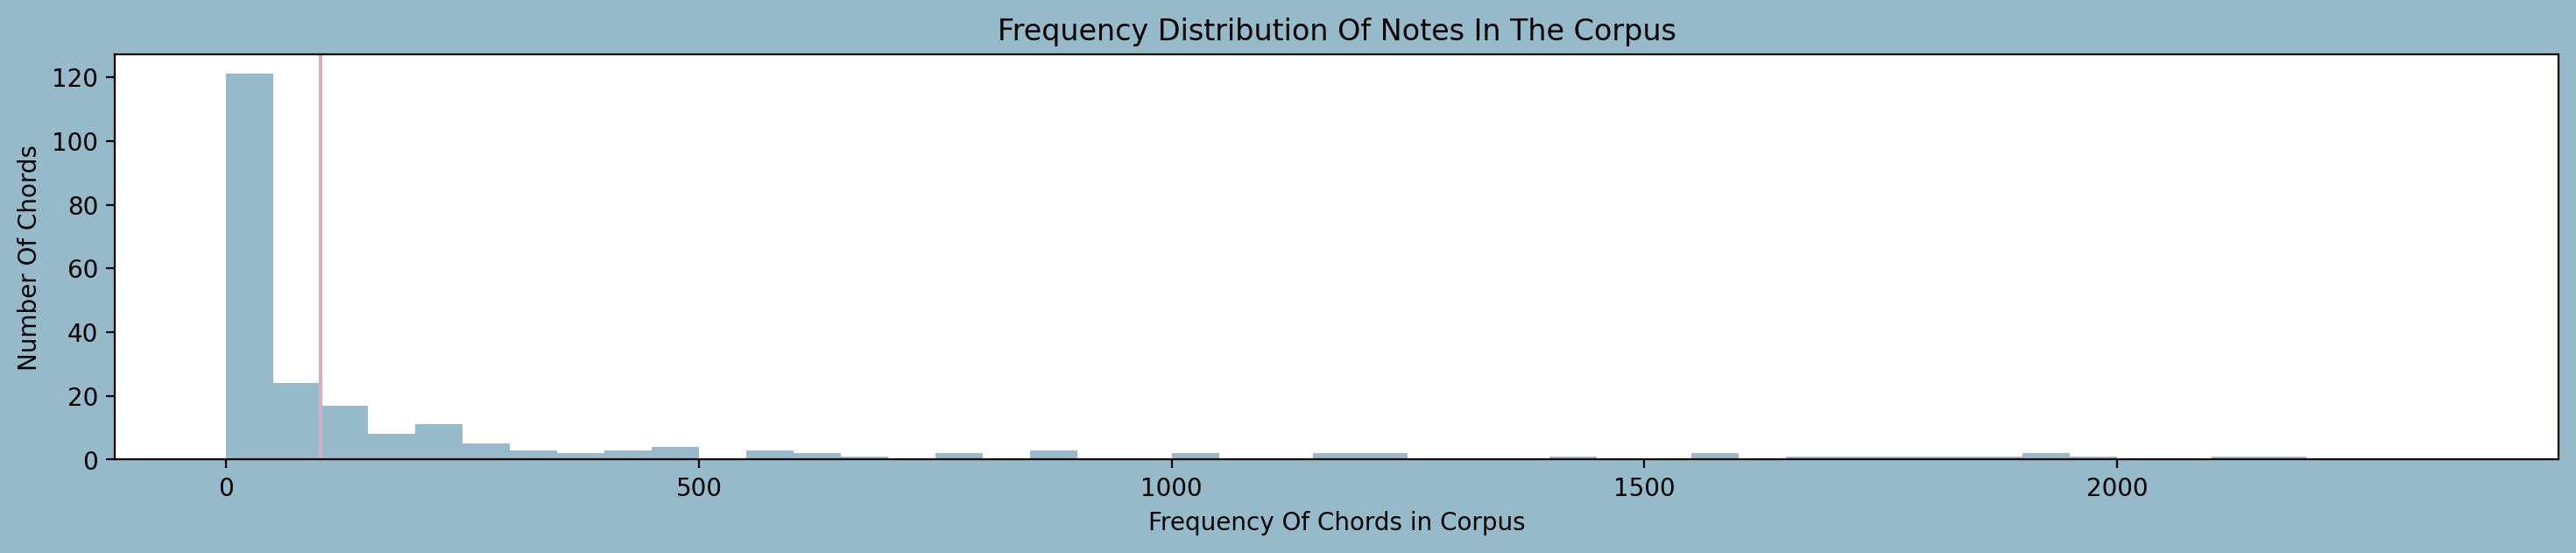

In [8]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [9]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 10:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 10 times:", len(rare_note))

Total number of notes that occur less than 10 times: 69


In [10]:
Corpus_clean = [note for note in Corpus if note not in rare_note]

print("Length of Corpus after eliminating the rare notes:", len(Corpus_clean))

Length of Corpus after eliminating the rare notes: 55501


## **3.DATA PREPROCESSING**

**3.1 Creating a list of sorted unique characters**

In [11]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
#to build dictionary of ‘key to valuedictionary’ and dictionary of ‘value to key’
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 55802
Number of unique characters: 229


In [12]:
mapping['2.4.9']

62

**3.2 Save dataset**

In [13]:
import pickle

# 保存数据
with open('mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

with open('reverse_mapping.pkl', 'wb') as f:
    pickle.dump(reverse_mapping, f)

with open('L_corpus.pkl', 'wb') as f:
    pickle.dump(L_corpus, f)

with open('L_symb.pkl', 'wb') as f:
    pickle.dump(L_symb, f)
    
with open('Corpus.pkl', 'wb') as f:
    pickle.dump(Corpus, f)
